In [15]:
import pandas as pd

In [19]:
gt = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcls_2016/RASQUAL/rasqual_atac_1M.gz", sep='\t', header=None)


In [20]:
gt.head(1)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Peak1,rs10454458,1,737085,C,T,0.083333,0.198347,0.476176,0.8868,...,3.606369,0,624,7,11,737085,0.0,0,NaN,0.669344


In [2]:
qvals = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl/Q.val.txt", sep="\t", header=None, names=["peakid", "qval"])

In [3]:
sig_peaks = open("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl/pid.fdr10.txt").readlines()
sig_peaks_ids = [line.strip() for line in sig_peaks]
sig_peaks_ids = qvals[qvals["qval"]<0.1]["peakid"].values

In [4]:
data_atac = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl/ATAC/summary.mean.variant_scores_new.tsv", sep="\t", header=0)
data_atac[['Chrx', 'Posx', 'REF', 'ALT', 'Peak_id', 'obs_scores']] = data_atac['rsid'].str.split("_", expand=True)
data_atac["obs_scores"] = data_atac["obs_scores"].astype(float)

In [5]:
data_dnase = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcl/DNASE/summary.mean.variant_scores_new.tsv", sep="\t", header=0)
data_dnase[['Chrx', 'Posx', 'REF', 'ALT', 'Peak_id', 'obs_scores']] = data_dnase['rsid'].str.split("_", expand=True)
data_dnase["obs_scores"] = data_dnase["obs_scores"].astype(float)

In [6]:
peaks_data = pd.read_csv("/mnt/lab_data2/anusri/variant-scorer/src/output/caqtls_lcls_2016/RASQUAL/peaks.bed.gz", sep='\t', header=None)

In [7]:
peaks_data.head(1)

,0,1,2,3,4,5,6,7
0,1,9913,10650,Peak1,"9913,","10650,",738,49.864499


In [8]:
data_atac=data_atac.merge(peaks_data, right_on=[3], left_on=["Peak_id"], how="left" )
data_dnase=data_dnase.merge(peaks_data, right_on=[3], left_on=["Peak_id"], how="left" )

In [25]:
data_dnase["center"] = (data_dnase[1]+data_dnase[6])
data_atac["center"] = (data_dnase[1]+data_dnase[6])
data_dnase["dist"] = abs(data_dnase["pos"]-data_dnase["center"])
data_atac["dist"] = abs(data_atac["pos"]-data_atac["center"])
print(sum(data_dnase["dist"]<100))
print(sum(data_dnase[data_dnase["dist"]<100]["Peak_id"].isin(sig_peaks_ids)))

117
41


In [26]:
data_atac=data_atac.merge(qvals, right_on=["peakid"], left_on=["Peak_id"], how="left" )
data_dnase=data_dnase.merge(qvals, right_on=["peakid"], left_on=["Peak_id"], how="left" )

In [47]:
import numpy as np
data_dnase1 = data_dnase[data_dnase["dist"]<100].reset_index()
data_atac1 = data_atac[data_atac["dist"]<100].reset_index()
# data_dnase1["log10qval"] = np.log10(data_dnase1["qval"])*-1
# data_atac1["log10qval"] = np.log10(data_atac1["qval"])*-1

In [48]:
data_dnase2 = data_dnase[(data_dnase["pos"] >= data_dnase[1]) & (data_dnase["pos"] < data_dnase[2]) ]
data_atac2 = data_atac[(data_atac["pos"] >= data_atac[1]) & (data_atac["pos"] < data_atac[2]) ]
# data_dnase2["log10qval"] = np.log10(data_dnase2["qval"])*-1
# data_atac2["log10qval"] = np.log10(data_atac2["qval"])*-1

In [49]:
print(data_dnase2.shape)
print(sum(data_dnase2["Peak_id"].isin(sig_peaks_ids)))

(1934, 38)
841


In [67]:
len(data_atac1[data_atac1["qval"]==0])

7

In [68]:
data_dnase2.shape

(1934, 38)

In [81]:
from sklearn import metrics
from scipy.stats import pearsonr
chrombpnet = {}
chrombpnet["ChromBPNet DNase (68M)"] = []
chrombpnet["ChromBPNet ATAC (572M)"] = []
random_bc = []

pearsonr_atac = []
pearsonr_dnase = []
for qth in np.arange(0,0.1+0.005,0.005):
    #print(qth)
    data1 = data_dnase2[data_dnase2["qval"]<=qth]
    data1["label"]=1
    
pearsonr(data1["logfc.mean"], data1)
    data2 = data_dnase2[data_dnase2["qval"]>0.15]
    data2["label"]=0
    
    dataf = pd.concat([data1, data2])
    total = dataf.shape[0]
    sigs = sum(dataf["label"])
    print(sigs)
    print(total)
    print(np.round(sigs/total,3))

    roc_auc = metrics.average_precision_score(dataf["label"], abs(dataf["abs_logfc_x_jsd_x_max_percentile.mean"]))
    chrombpnet["ChromBPNet DNase (68M)"].append(roc_auc)
for qth in np.arange(0,0.1+0.005,0.005):
    data1 = data_atac2[data_atac2["qval"]<=qth]
    data1["label"]=1
    data2 = data_atac2[data_atac2["qval"]>0.15]
    data2["label"]=0


    dataf = pd.concat([data1, data2])
    total = dataf.shape[0]
    sigs = sum(dataf["label"])
    print(sigs)
    print(total)
    print(np.round(sigs/total,3))
    
    random_bc.append(np.round(sigs/total,5))

    roc_auc = metrics.average_precision_score(dataf["label"], abs(dataf["abs_logfc_x_jsd_x_max_percentile.mean"]))
    chrombpnet["ChromBPNet ATAC (572M)"].append(roc_auc)


/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/users/anusri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

146
1125
0.13
321
1300
0.247
377
1356
0.278
479
1458
0.329
508
1487
0.342
549
1528
0.359
581
1560
0.372
612
1591
0.385
637
1616
0.394
667
1646
0.405
681
1660
0.41
701
1680
0.417
726
1705
0.426
750
1729
0.434
762
1741
0.438
769
1748
0.44
786
1765
0.445
796
1775
0.448
812
1791
0.453
829
1808
0.459
841
1820
0.462
146
1125
0.13
321
1300
0.247
377
1356
0.278
479
1458
0.329
508
1487
0.342
549
1528
0.359
581
1560
0.372
612
1591
0.385
637
1616
0.394
667
1646
0.405
681
1660
0.41
701
1680
0.417
726
1705
0.426
750
1729
0.434
762
1741
0.438
769
1748
0.44
786
1765
0.445
796
1775
0.448
812
1791
0.453
829
1808
0.459
841
1820
0.462


Text(0.5, 0, 'increasing signficance (decreasing qval)')

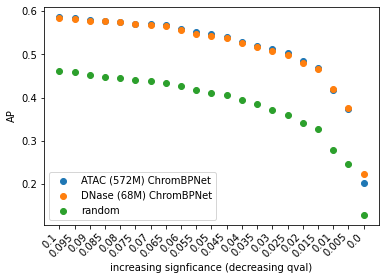

In [83]:
import matplotlib.pyplot as plt

plt.scatter(np.flip(np.arange(0,0.1+0.005,0.005)).astype(str), np.flip(chrombpnet["ChromBPNet ATAC (572M)"]), label="ATAC (572M) ChromBPNet")
plt.scatter(np.flip(np.arange(0,0.1+0.005,0.005)).astype(str), np.flip(chrombpnet["ChromBPNet DNase (68M)"]), label="DNase (68M) ChromBPNet")
plt.scatter(np.flip(np.arange(0,0.1+0.005,0.005)).astype(str), np.flip(random_bc), label="random")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.ylabel("AP")
plt.xlabel("increasing signficance (decreasing qval)")

In [84]:
data1.columns

Index([                                       'chr',
                                              'pos',
                                          'allele1',
                                          'allele2',
                                             'rsid',
                                       'logfc.mean',
                                   'abs_logfc.mean',
                              'abs_logfc.mean.pval',
                                         'jsd.mean',
                                    'jsd.mean.pval',
                                 'logfc_x_jsd.mean',
                             'abs_logfc_x_jsd.mean',
                        'abs_logfc_x_jsd.mean.pval',
                      'logfc_x_max_percentile.mean',
                  'abs_logfc_x_max_percentile.mean',
             'abs_logfc_x_max_percentile.mean.pval',
                        'jsd_x_max_percentile.mean',
                   'jsd_x_max_percentile.mean.pval',
            'abs_logfc_x_jsd_x_max_percentile.

In [70]:
import numpy as np
data_atac_sig["jsd_sign.mean"] = data_atac_sig["jsd.mean"]*np.sign(data_atac_sig["logfc.mean"])
data_dnase_sig["jsd_sign.mean"] = data_dnase_sig["jsd.mean"]*np.sign(data_dnase_sig["logfc.mean"])


(0.6744185283131905, 1.2080274872385788e-112)


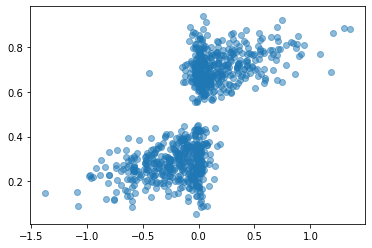

In [75]:
plt.scatter(data_dnase_sig["logfc.mean"], data_dnase_sig["obs_scores"], alpha=0.5)
print(scipy.stats.pearsonr(data_dnase_sig['obs_scores'],data_dnase_sig['logfc.mean']))

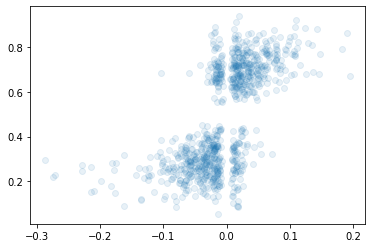

In [72]:
plt.scatter(data_dnase_sig["jsd_sign.mean"], data_dnase_sig["obs_scores"], alpha=0.1)

In [74]:
import scipy.stats

print(scipy.stats.pearsonr(data_atac_sig['obs_scores'],data_atac_sig['abs_logfc_x_jsd_x_max_percentile.mean']))

(-0.03014559908424015, 0.11686422647093589)


In [18]:
print(scipy.stats.pearsonr(data_atac_sig['obs_scores'],data_atac_sig['logfc_x_jsd.mean']))


(0.2811877545943154, 2.257738745972026e-50)


In [24]:
import scipy.stats

print(scipy.stats.pearsonr(data_atac_sig['obs_scores'],data_atac_sig['jsd_sign.mean']))

(0.3730024279092575, 4.126979535936469e-90)


In [23]:
#print(scipy.stats.pearsonr(data_atac_sig[data_atac_sig["peak_overlap"]]['obs_scores'],data_atac_sig[data_atac_sig["peak_overlap"]]['logfc_x_jsd_x_max_percentile.mean']))



In [20]:
#print(scipy.stats.pearsonr(data_atac_sig[data_atac_sig["peak_overlap"]]['obs_scores'],data_atac_sig[data_atac_sig["peak_overlap"]]['jsd_sign.mean']))


In [21]:
#plt.scatter(data_atac_sig[data_atac_sig["peak_overlap"]]["logfc_x_jsd_x_max_percentile.mean"], data_atac_sig[data_atac_sig["peak_overlap"]]["obs_scores"]-0.5, alpha=0.5)

In [22]:
#plt.scatter(data_atac_sig[data_atac_sig["peak_overlap"]]["jsd_sign.mean"], data_atac_sig[data_atac_sig["peak_overlap"]]["obs_scores"]-0.5, alpha=0.5)



156

In [94]:
data_atac_sig = data_atac[data_atac["Peak_id"].isin(sig_peaks_ids)].drop_duplicates()
data_atac_nonsig = data_atac[~data_atac["Peak_id"].isin(sig_peaks_ids)].drop_duplicates()
data_atac_sig["obs_scores"] = data_atac_sig["obs_scores"].astype(float)
data_atac_nonsig["obs_scores"] = data_atac_nonsig["obs_scores"].astype(float)

In [95]:
print(np.mean(data_atac_sig['obs_scores']))
print(np.mean(data_atac_nonsig['obs_scores']))


0.4763933590690797
0.4718914237544454


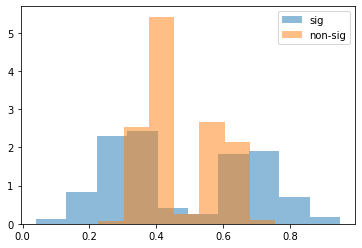

In [96]:
plt.hist(data_atac_sig['obs_scores'], density=True, alpha=0.5, label="sig")
plt.hist(data_atac_nonsig['obs_scores'],density=True, alpha=0.5, label="non-sig")
plt.legend()